# Open Street Map

By making use of the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library we can fetch [OpenStreetMap](https://www.openstreetmap.org/) data and use it in [MGSurvE](https://github.com/Chipdelmal/MGSurvE)! This time, we will start by loading the library and setting up some of its internal parameters:

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
# Load libraries --------------------------------------------------------------
import osmnx as ox
import numpy as np
import pandas as pd
from math import exp
from copy import deepcopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import MGSurvE as srv
ox.settings.log_console=False
ox.settings.use_cache=True
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('Banfora', './out/')
srv.makeFolder(OUT_PTH)

## Downloading Buildings Footprints

In this example, we will download the data of a section of Banfora, Burkina Faso. To do this, we will center our reference point at the `(10.63524, -4.75195)` coordinates and set an altitude of `250` meters:

In [2]:
(COORDS, DIST) = ((10.63524, -4.75195), 250)
# Scrape building footprints to dataframe -------------------------------------
BLD = ox.features.features_from_point(
    COORDS, tags={'building': True} , dist=DIST
)
NTW = ox.graph_from_point(
    COORDS, dist=DIST, network_type='all',
    retain_all=True, simplify=True, truncate_by_edge=True
)
# Extend the original dataframe to contain the centroids of geometries --------
BLD['centroid_lon'] = [poly.centroid.x for poly in BLD['geometry']]
BLD['centroid_lat'] = [poly.centroid.y for poly in BLD['geometry']]
BLD.reset_index(inplace=True)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


The `BLD` dataframe contains all the information we need to generate a map of the location and we can, additionally, plot the roads by projecting the `NTW` graph:

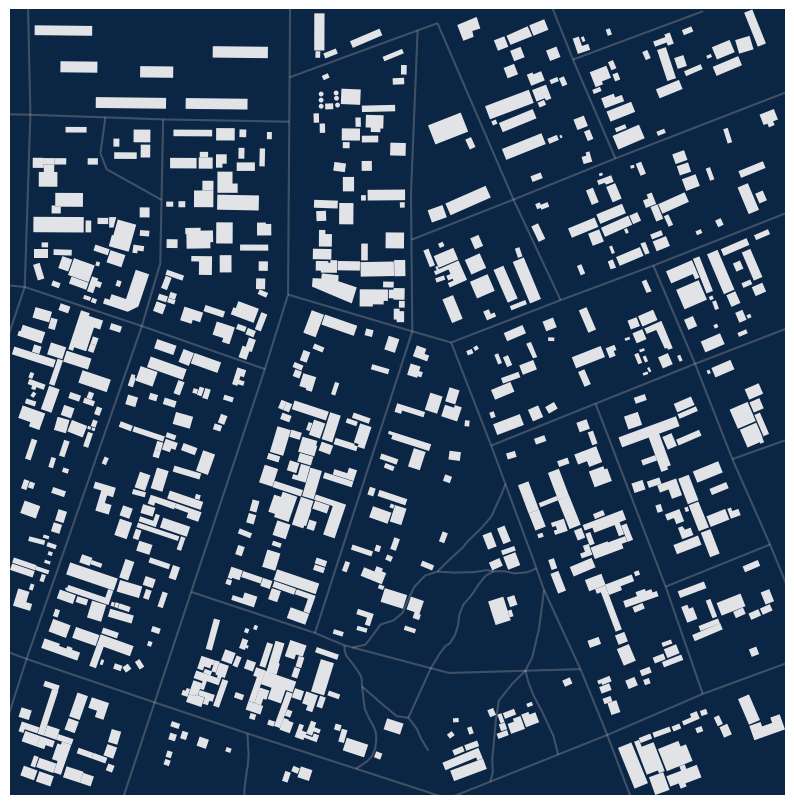

In [3]:
STYLE_BG = {'color': '#0b2545'}
STYLE_BD = {'color': '#faf9f9', 'alpha': 0.900}
STYLE_RD = {'color': '#ede0d4', 'alpha': 0.125, 'width': 1.5}
# Project and plot map --------------------------------------------------------
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, node_size=0, figsize=(10, 100), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)

## Generating MGSurvE Landscape

If we wanted to make use of our data in [MGSurvE](https://github.com/Chipdelmal/MGSurvE), one simple way we can go about it is by using the `centroid_lon` and `centroid_lat` to generate our migration matrix and landscape:

In [4]:
lonLats = np.array(list(zip(BLD['centroid_lon'], BLD['centroid_lat'])))
migDst = srv.calcDistanceMatrix(lonLats, distFun=srv.haversineDistance)

This time, we will define a custom exponential kernel. To do this we just need to define a function that takes the distance matrix as an argument, applies a function upon it based on the distance between every pair-wise combination of points (an exponential decay one, in this case), and returns a row-normalized migration probability matrix:

In [5]:
# Defining our custom migration kernel ----------------------------------------
def exponentialKernel(distMat, decay):
    coordsNum = len(distMat)
    migrMat = np.empty((coordsNum, coordsNum))
    for (i, row) in enumerate(distMat):
        for (j, dst) in enumerate(row):
            migrMat[i][j] = exp(-decay*dst)
        for j in range(len(row)):
            if np.isnan(migrMat[i][j]):
                migrMat[i][j] = 0
    tauN = normalize(migrMat, axis=1, norm='l1')
    return np.array(tauN)
# Calculating the full migration matrix ---------------------------------------
MEAN_LIFETIME_DISPERSAL = 25
migMat = exponentialKernel(migDst, 1/MEAN_LIFETIME_DISPERSAL)

We now generate our sites dataframe:

In [6]:
# Generate sites dataframe ----------------------------------------------------
sites = pd.DataFrame(lonLats, columns=['lon', 'lat'])
sites['t'] = [0]*sites.shape[0]
# Get the bounding box and centroid -------------------------------------------
BBOX = (
    (min(sites['lon']), max(sites['lon'])),
    (min(sites['lat']), max(sites['lat']))
)

And define the traps we want to optimize:

In [7]:
TRPS_NUM = 5
(initLon, initLat) = (
    sites.iloc[0]['lon']*TRPS_NUM, 
    sites.iloc[0]['lat']*TRPS_NUM
)
sid = [0]*TRPS_NUM
traps = pd.DataFrame({
    'sid': sid, 'lon': initLon, 'lat': initLat, 
    't': [0]*TRPS_NUM, 'f': [0]*TRPS_NUM
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': 0.5, 'b': 0.041674}}}

With these pieces in place, we can now define our landscape object:

In [8]:
lnd = srv.Landscape(
    sites, 
    migrationMatrix=migMat, kernelFunction=exponentialKernel, 
    distanceFunction=srv.haversineDistance,
    kernelParams={'decay': 1/MEAN_LIFETIME_DISPERSAL},
    traps=traps, trapsKernels=tKer, trapsRadii=[0.250, 0.125, 0.100],
    landLimits=BBOX
)
bbox = lnd.getBoundingBox()
trpMsk = srv.genFixedTrapsMask(lnd.trapsFixed)

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/MGSurvE/kernels.py:156: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob = A * math.exp(-b * dist)


## Optimizing 

We will run discrete optimization upon our landscape as follows:

In [9]:
GENS = 200
VERBOSE = True
POP_SIZE = int(10*(lnd.trapsNumber*1.5))
(MAT, MUT, SEL) = (
    {'cxpb':  0.300, 'indpb': 0.35}, 
    {'mutpb': 0.375, 'indpb': 0.50},
    {'tSize': 3}
)
lndGA = deepcopy(lnd)
# Running GA and exporting results --------------------------------------------
(lndDO, logbookDO) = srv.optimizeDiscreteTrapsGA(
    lndGA, pop_size=POP_SIZE, generations=GENS, verbose=VERBOSE,
    mating_params=MAT, mutation_params=MUT, selection_params=SEL,
    fitFuns={'inner': np.sum, 'outer': np.mean}
)
srv.exportLog(logbookDO, OUT_PTH, '{}_LOG_DO'.format(ID))
srv.dumpLandscape(lndDO, OUT_PTH, '{}_LND_DO'.format(ID), fExt='pkl')

gen	nevals	min    	avg    	max   	std    	best	traps                    
0  	75    	32.3037	47.8956	81.976	9.36861	62  	[487, 244, 222, 547, 389]
1  	43    	32.3037	44.9978	72.778	8.6824 	72  	[487, 244, 222, 547, 389]
2  	32    	32.3037	40.9889	66.9861	7.16073	4   	[487, 244, 222, 547, 389]
3  	40    	32.3037	39.6758	78.9259	8.49212	67  	[487, 244, 222, 547, 389]
4  	42    	31.4487	38.8205	61.2016	6.52007	51  	[336, 542, 16, 182, 406] 
5  	46    	31.4487	39.1564	71.3529	8.27858	54  	[336, 542, 16, 182, 406] 
6  	44    	30.8678	36.4007	52.9051	5.02218	15  	[301, 542, 62, 411, 444] 
7  	49    	29.7501	36.6874	58.648 	6.58643	28  	[301, 473, 62, 547, 389] 
8  	31    	29.7501	36.8322	83.2112	8.60524	12  	[301, 473, 62, 547, 389] 
9  	46    	29.7501	36.1331	76.2869	7.89195	36  	[301, 473, 62, 547, 389] 
10 	43    	29.7501	36.5968	75.2892	8.43283	0   	[301, 473, 62, 547, 389] 
11 	37    	29.7501	35.0003	58.3024	6.14873	4   	[301, 473, 62, 547, 389] 
12 	48    	29.7221	36.1418	63.4182	7.6738

And plot our results!

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


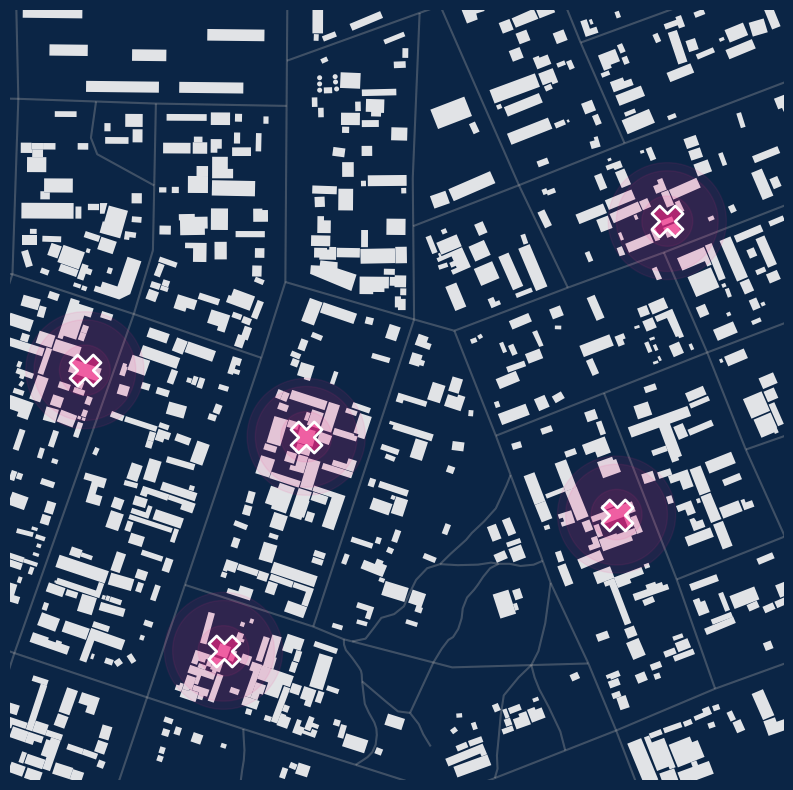

In [10]:
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lndDO.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}DO.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

Running the continuous case is also easy!

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min    	avg    	max    	std    	best	traps                                                                                                                                                                                                   
0  	62    	35.6036	55.7335	111.386	15.4452	48  	[-4.752754342909225, 10.633480104917048, -4.750146630366148, 10.636313528317975, -4.7520858654542995, 10.63374696331781, -4.752839326357562, 10.63529068970684, -4.7532141270775305, 10.636002209669105]
1  	46    	34.2028	72.431 	497.214	63.707 	24  	[-4.752419679652871, 10.633434706211581, -4.753376988020168, 10.63602134634664, -4.750856656155025, 10.63636646130161, -4.75352029448222, 10.634144409562541, -4.7523600308341685, 10.634626350085645]  
2  	41    	34.2028	96.9585	2187.61	271.349	32  	[-4.752419679652871, 10.633434706211581, -4.753376988020168, 10.63602134634664, -4.750856656155025, 10.63636646130161, -4.75352029448222, 10.634144409562541, -4.7523600308341685, 10.634626350085645]  
3  	

/Users/sanchez.hmsc/miniconda3/envs/MGSurvE_Webinar/lib/python3.10/site-packages/pyproj/transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


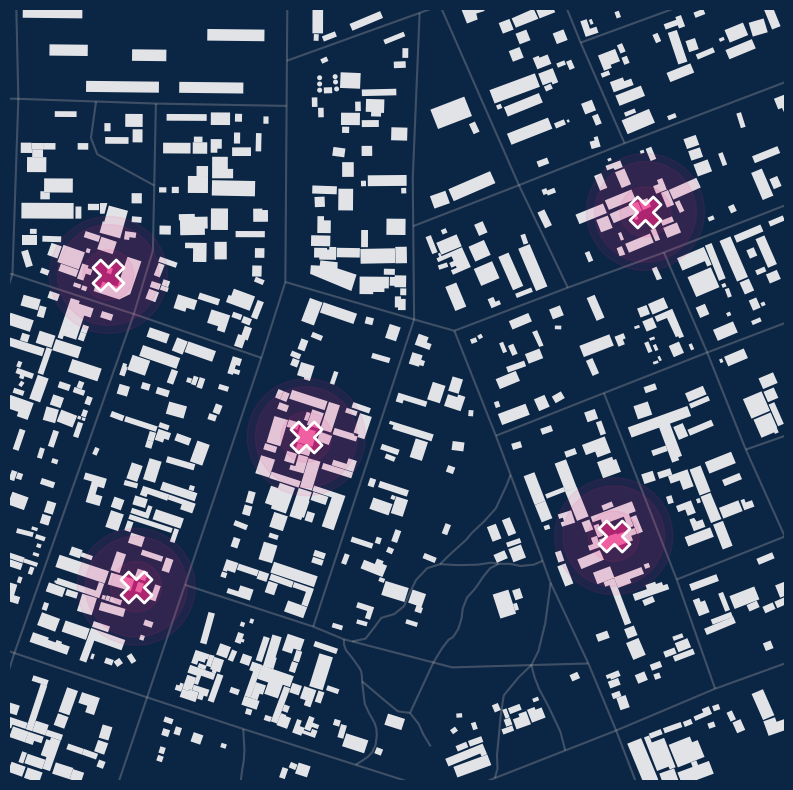

In [11]:
# Optimize the continuous landscape -------------------------------------------
(lndCO, logbookCO) = srv.optimizeTrapsGA(
    lndGA, 
    pop_size='auto', generations=GENS,
    mating_params='auto', mutation_params='auto', selection_params='auto',
    fitFuns={'inner': np.sum, 'outer': np.mean}, verbose=VERBOSE
)
srv.exportLog(logbookCO, OUT_PTH, '{}_LOG_CO'.format(ID))
srv.dumpLandscape(lndCO, OUT_PTH, '{}_LND_CO'.format(ID), fExt='pkl')
# Plot the results ------------------------------------------------------------
(fig, ax) = (
    plt.figure(figsize=(10, 10), facecolor=STYLE_BG['color']), 
    plt.axes(projection=ccrs.PlateCarree())
)
G = ox.project_graph(NTW, to_crs=ccrs.PlateCarree())
(fig, ax) = ox.plot_graph(
    G, ax, node_size=0, figsize=(40, 40), show=False,
    bgcolor=STYLE_BG['color'], edge_color=STYLE_RD['color'], 
    edge_alpha=STYLE_RD['alpha'], edge_linewidth=STYLE_RD['width']
)
(fig, ax) = ox.plot_footprints(
    BLD, ax=ax, save=False, show=False, close=False,
    bgcolor=STYLE_BG['color'], color=STYLE_BD['color'], 
    alpha=STYLE_BD['alpha']
)
lndDO.plotTraps(
    fig, ax, 
    size=500, zorders=(30, 25), transparencyHex='99', 
    proj=ccrs.PlateCarree()
)
srv.plotClean(fig, ax, bbox=BBOX)
ax.set_facecolor(STYLE_BG['color'])
fig.savefig(
    os.path.join(OUT_PTH, '{}CO.png'.format(ID)), 
    facecolor='w', bbox_inches='tight', pad_inches=0.1, dpi=150
)

<hr>

# More Information

* [OSMnx Documentation](https://osmnx.readthedocs.io/)
* [OpenStreetMap](https://www.openstreetmap.org)
